##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Optimization in TensorFlow Quant Finance (TFF)

TensorFlow Finance has built-in library for unconstrained numerical optimization. This notebook shows how to use it.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/aderdouri/ql_web_app/blob/master/tf_quant_finance_notebooks/Optimization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/aderdouri/ql_web_app/blob/master/tf_quant_finance_notebooks/Optimization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
#@title Upgrade to TensorFlow 2.1+
!pip install --upgrade tensorflow

In [0]:
#@title Install TF Quant Finance
!pip install tf-quant-finance

In [0]:
#@title Imports
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import functools
import matplotlib.colors as colors

import tf_quant_finance.math.optimizer as tff_optimizer

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

tf.compat.v1.enable_eager_execution()
figsize(12, 8)

In [0]:
# Decorator for automatic gradient evaluation.
def make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad

## Simple example

Below is an example of optimizing a function in TensorFlow Finance.

In [3]:
# Define a function.
@make_val_and_grad_fn
def func(x):
  return (1 - x[0])**2 + 100*(x[1]-x[0]**2)**2

# Start point for optimization.
start = tf.constant([0.0, 0.0], dtype=tf.float64)

# Optimize
result = tff_optimizer.conjugate_gradient_minimize(func, start)
print("Argmin: %s" % result.position.numpy())
print("Objective value at argmin: %s" % result.objective_value.numpy())


Argmin: [1. 1.]
Objective value at argmin: 2.9042834203951543e-18


In this example we used the Conjugate Gradinet optimization algorithm to optimize a function $f$ of two variables, defined as

$$f(x, y) = (1-x)^2 + 100(y-x^2)^2.$$

This is the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) and it has single local minimum $f(1, 1) = 0$, which is also a global minimum.

We had to supply two things to the algorithm:

* Callable which given a point $\mathbf{x}$ calculates objective value at the point $f(\mathbf{x})$ and gradient at the point $\nabla f(\mathbf{x})$.

* Initial position. Conjugate Gradient method is an iterative method, i.e. it builds a sequence of points approaching the minimum. It needs to know at which point to start. In our case it is the origin (0, 0). Algorithm also uses initial position to infer dimensionality of the function domain and dtype which will be used to do all calculations.


## Automatic differentiation

In example below we didn't explicitly specify gradient of objective function. That's because TensorFlow supports automatic differentiation. If you define a differentiable function using only TensorFlow ops that support gradients, you will be able to calculate its derivative at any point automatically.

We used decorator `make_val_and_grad_func` to make from function which evaluates $f(\mathbb{x})$ function which evaluates pair $f(\mathbb{x}), \nabla f(\mathbb{x}).$ This decorator was defined at the top of this notebook.

In principle, we could explicitly specify gradient:

In [4]:
def func_and_grad(position):
  x, y = position[0], position[1]
  func = (1 - x)**2 + 100*(y-x**2)**2
  grad = tf.stack([
    2* (x-1) - 400*(y-x**2) * x,
    200 * (y-x**2)               
  ])
  return func, grad

result = tff_optimizer.conjugate_gradient_minimize(func_and_grad, start)
print(result.position.numpy())

[1. 1.]


But we recommend to always use automatic differentiation.

## Tolerance

Conjugate Gradient algorithm stops if any of following conditions is satisifed:

* Maximum number of iterations (specified by parameter `max_iterations`) is reached;
* Norm of gradient is not greater than `tolerance`. Note that norm is inf-norm, i.e. maximal absolute value over all coordinates of gradient;
* Relative difference between values of objective function on $i$-th and $(i+1)$-th iterations is not greater than `f_relative_tolerance`;
* Inf-norm between positions on $i$-th and $(i+1)$-th iterations is not greater than `x_tolerance`.

Parameters `max_iterations`, `tolerance`, `f_relative_tolerance` and `x_tolerance` are parameters of optimization algorithm.
By default `x_tolerance` and `f_relative_tolerance` are set to 0.

Gradient tolerance is an important parameter. If it is too small, algorithm may perform many iterations in the neigborhood of the local minimum but never stop. If it is too big, algorithm may terminate too far from the minimum. Default value is $10^{-8}$.

Example below shows how number of iterations and number of objective evaluations needed for optimization to converge depend on gradient tolerance. 

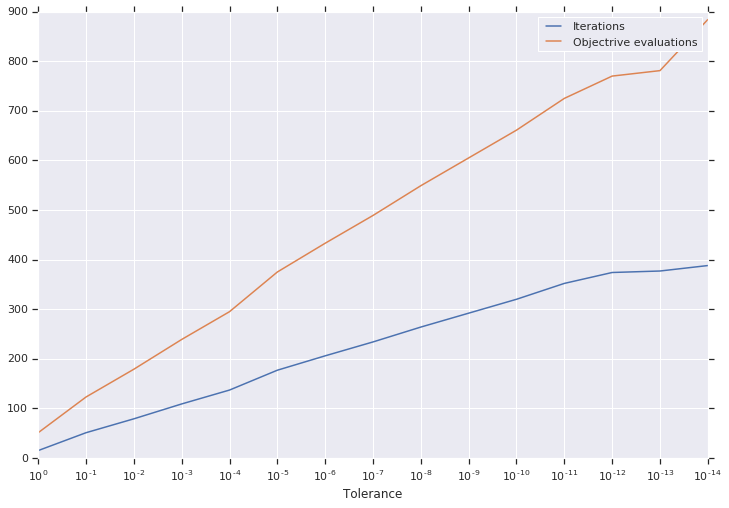

In [7]:
@make_val_and_grad_fn
def rosenbrock(x):
  return 100 * tf.reduce_sum(tf.square(x[1:] - tf.square(x[:-1]))) + \
      tf.reduce_sum(tf.square(1 - x[:-1]))

start = tf.zeros(4, dtype=tf.float64)
tolerance_range = []
num_iterations = []
num_func_calls = []
for x in range(15):
  tolerance = 10.0**(-x)
  result = tff_optimizer.conjugate_gradient_minimize(
      rosenbrock, 
      start, 
      max_iterations=1000, 
      tolerance=tolerance)
  tolerance_range.append(tolerance)
  num_iterations.append(result.num_iterations.numpy())
  num_func_calls.append(result.num_objective_evaluations.numpy())

plt.plot(tolerance_range, num_iterations, label='Iterations')
plt.plot(tolerance_range, num_func_calls, label='Objectrive evaluations')
plt.semilogx()
plt.xlim(1, 1e-14)
plt.xlabel('Tolerance')
plt.legend()
plt.show()

## Adjustable parameters

The Conjugate Gradient algorithm has several adjustable parameters. These parameters can be passed using the `params` argument. For details on the parameters refer
to the [source code](https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/math/optimizer/conjugate_gradient.py) and [this article](http://users.clas.ufl.edu/hager/papers/CG/cg_compare.pdf).

The example below shows how to adjust custom algorithm parameters. We will vary the parameter $\sigma$ and see how that affects the number of iterations and the number of objective evaluations needed for convergence.

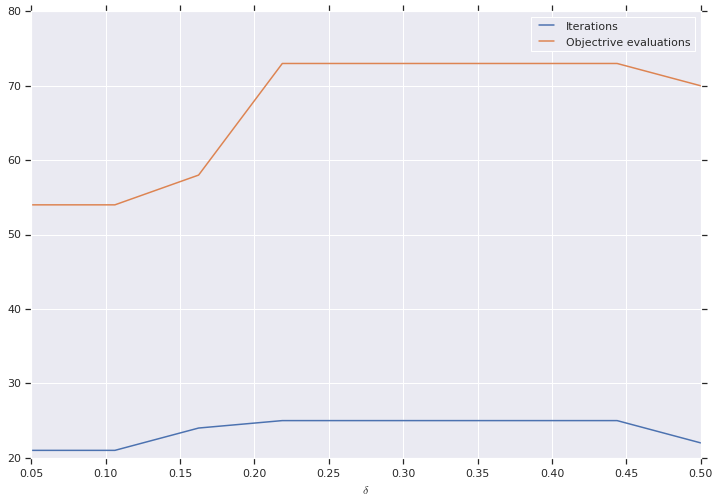

In [8]:
@make_val_and_grad_fn
def func(x):
  return (1 - x[0])**2 + 100*(x[1]-x[0]**2)**2

start = tf.zeros(2, dtype=tf.float64)
delta_range = np.linspace(0.05, 0.5, 9) 
num_iterations = []
num_func_calls = []
for delta in delta_range:
  result = tff_optimizer.conjugate_gradient_minimize(
      func, 
      start, 
      max_iterations=1000,
      params = tff_optimizer.ConjugateGradientParams(
          sufficient_decrease_param=delta))
  num_iterations.append(result.num_iterations.numpy())
  num_func_calls.append(result.num_objective_evaluations.numpy())
  
plt.plot(delta_range, num_iterations, label='Iterations')
plt.plot(delta_range, num_func_calls, label='Objectrive evaluations')
plt.xlabel(r'$\delta$')
plt.legend()
plt.show()

## Batching

Batching is a powerful feature of TensorFlow. It is an ability to perform the same operations with different components of tensors in parallel. Optimization algorithms in TensorFlow Finance are designed to support batching (although batches can only be 1-dimensional).

There are two use cases when batches may be useful:

* You have one function, but want to try optimizing it starting from different initial positions.

* You have a parametrized family of functions, and you want to optimize all of them in parallel.

## Batching example: one function, many starting points.

Assume you have a function with several local minima and you want to find all of them.

One way to do so is to perform optimization several times, starting from different inital positions. With batching you can invoke optimization only once, with batch of different inital positions. For this you will have to specify objective function in such a way so it supports batching.

For example let's consider [Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function). It has 4 local minima. Let's start optimizing from 30 different random points and plot optimization paths for each of these points.

For demonstration, to get intermediary position on each iteration, we will invoke algorithm with different values of `max_iter`. On practice you will have to only invoke it once with `max_iter` sufficiently big for all paths to converge. 

All converged after 22 iterations


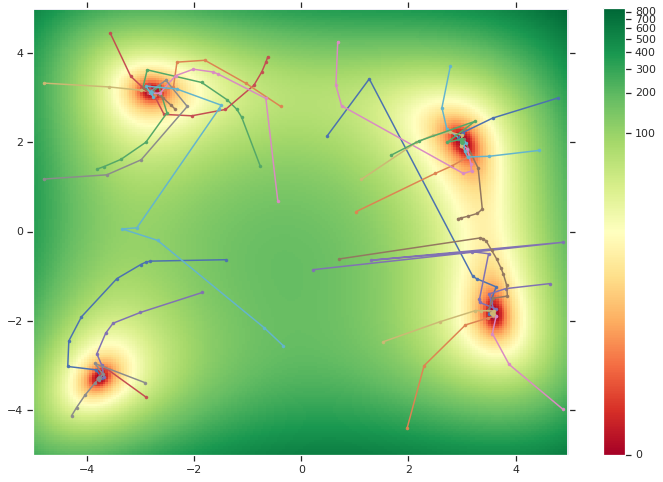

In [9]:
def himmelblau_function(x, y):
  return (x * x + y - 11) ** 2 + (x + y * y - 7) ** 2

@make_val_and_grad_fn
def objective(coord):
  return himmelblau_function(coord[..., 0], coord[..., 1])

np.random.seed(0)
starts = tf.constant(np.random.uniform(-5, 5, (30, 2)), dtype='float64')

paths = []
for iter_count in range(100):
  results = tff_optimizer.conjugate_gradient_minimize(
      objective, 
      initial_position=starts,
      tolerance=1e-8, 
      max_iterations=iter_count)
  paths.append(results.position.numpy())
  if (np.all(results.converged.numpy())):
    print('All converged after %d iterations' % iter_count)
    break

# Show the function.
x, y = np.meshgrid(np.arange(-5, 5, 0.05), np.arange(-5, 5, 0.05))
z = himmelblau_function(x, y)
plt.pcolormesh(x, y, z, cmap='RdYlGn', 
               norm=colors.SymLogNorm(2),
               vmin=np.min(z), vmax=np.max(z))
plt.colorbar()

# Show the paths.
paths = np.array(paths)
paths_x = paths[:,:,0].T
paths_y = paths[:,:,1].T
for i in range(len(starts)):
  plt.plot(paths_x[i], paths_y[i], marker = '.')

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()  

We can see, that any path converges to one of four minima.

## Batching example: stopping condition

Sometimes you might want to find any local minimum, but start from multiple starting points. In this case it's not necessary to wait until all paths converge.

Conjugate Gradient algorithm supports parameter `stopping_condition` which specify when to stop optimization. It is a function which takes two boolean tensors, one indicating which optimization paths converged and other - which failed. By default optimization will terminate when all paths converged or failed.

However, if you pass `tff_optimizer.converged_any`, algorithm will terminate if at least one path converged (or all failed).

In [10]:
results = tff_optimizer.conjugate_gradient_minimize(
    objective, 
    initial_position=starts,
    tolerance=1e-8,
    stopping_condition=tff_optimizer.converged_any)

assert np.any(results.converged.numpy())
print('Converged after %d iterations.' % results.num_iterations)
found_minima = tf.boolean_mask(results.position, results.converged).numpy()
print('Found minima: %s' % found_minima)

Converged after 7 iterations.
Found minima: [[-2.80511809  3.13131252]
 [-2.80511809  3.13131252]
 [-3.77931025 -3.28318599]]


You can see that to converge from all points took 22 iterations, but to converge from any point took only 7 iterations, and we found 2 of 4 minima.

In the same way you can specify `stopping_condition` for BFGS and L-BFGS algorithms.

## Batching example: multiple functions.

Let's consider a simple family of $n$ quadratic functions: 
$f_i(\mathbf{x}) = \|\mathbf{x} - \mathbf{a}_i\|^2_2$. Obviously, minimum of $f_i$ is at the point $\mathbf{a}_i$. Example below shows how to optimize all such functions simultaneously.



In [0]:
np.random.seed(12345)
dim = 100  # Dimensionality of domain.
n = 500    # Number of functions.
a = np.random.randn(n, dim)

@make_val_and_grad_fn
def quadratic(x):
  return tf.reduce_sum((x - a) ** 2, axis=-1)

results = tff_optimizer.conjugate_gradient_minimize(
      quadratic, 
      initial_position=tf.zeros((n, dim), dtype=tf.float64),
      max_iterations=200)

assert np.allclose(results.position.numpy() - a, 1e-8)

## Algorithms overview

Code above demonstrates how to use Conjugate Gradient algorithm. TensorFlow Finance provides also implementations of others optimization algorithms:

* **[Conjugate Gradient method](https://en.wikipedia.org/wiki/Nonlinear_conjugate_gradient_method)**. This is a first-order method.

* **[BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)**. This is Quasi-Newton first-order method. It needs $O(N^2)$ memory ($N$ - domain dimensionality) to approximate the Hessian matrix, so it may not work for large $N$.

* **[L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS)**. This is optimized version of BFGS which uses less memory.

* **[Nelder-Mead](https://en.wikipedia.org/wiki/Nelder–Mead_method)**. This is gradient free method, i.e. it doesn't need gradient. It can be used to optimize non-differentiable function (or a function for which gradient can't be easily computed), but it typically will perform many more evaluations of the objective function than first-order methods.

Example below optimizes the same function with all available algorithms.

In [12]:
def rosenbrock(x):
  return 100 * tf.reduce_sum(tf.square(x[1:] - tf.square(x[:-1]))) + \
      tf.reduce_sum(tf.square(1 - x[:-1]))
rosenbrock_with_gradient = make_val_and_grad_fn(rosenbrock)
start = tf.zeros(7, dtype=tf.float64)

# Conjugate Gradient.
result = tff_optimizer.conjugate_gradient_minimize(
    rosenbrock_with_gradient,
    start,
    tolerance=1e-4,
    max_iterations=1000)
assert(np.allclose(result.position.numpy(), np.ones(7), 1e-4))
print("Objective evaluations with Conjugate Gradient: %d" % 
      result.num_objective_evaluations.numpy())


# BFGS.
result = tff_optimizer.bfgs_minimize(
    rosenbrock_with_gradient,
    start,
    tolerance=1e-4,
    max_iterations=1000)
assert(np.allclose(result.position.numpy(), np.ones(7), 1e-4))
print("Objective evaluations with BFGS: %d" % 
      result.num_objective_evaluations.numpy())

# L-BFGS.
result = tff_optimizer.lbfgs_minimize(
    rosenbrock_with_gradient, 
    start,
    tolerance=1e-4,
    max_iterations=1000)
assert(np.allclose(result.position.numpy(), np.ones(7), 1e-4))
print("Objective evaluations with L-BFGS: %d" % 
      result.num_objective_evaluations.numpy())

# Nelder-Mead.
result = tff_optimizer.nelder_mead_minimize(
    rosenbrock, 
    initial_vertex=start,
    position_tolerance=1e-4,
    max_iterations=1000)
assert(np.allclose(result.position.numpy(), np.ones(7), 1e-4))
print("Objective evaluations with Nelder-Mead: %d" % 
      result.num_objective_evaluations.numpy())

Objective evaluations with Conjugate Gradient: 297
Objective evaluations with BFGS: 124
Objective evaluations with L-BFGS: 107
Objective evaluations with Nelder-Mead: 1493


For more examples on BFGS, L-BFGS and Nelder-Mead methods, refer to [this example](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Optimizers_in_TensorFlow_Probability.ipynb) from TensorFlow Probability.